In [1]:
import time
import zlib
import gzip
import blosc
import lzo
import snappy
import numpy as np
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt

from collections import OrderedDict
from functools import partial

from preprocess import PreprocessWrapper

In [2]:
gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array", frameskip=1, repeat_action_probability=0)
env = PreprocessWrapper(env, 4, 'cpu')
x, info = env.reset(seed=42)
frames = [x]
x, _, _, _, _ = env.step(1)
frames.append(x)
x, _, _, _, _ = env.step(2)
frames.append(x)
x, _, _, _, _ = env.step(2)
frames.append(x)
env.close()
x = x.numpy()
x = np.concatenate(frames, axis=1)
x.shape

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


(1, 4, 84, 84)

In [3]:
def evaluate(compress_fn, decompress_fn, x):
    t0 = time.time()
    compressed = compress_fn(x.tobytes())
    compress_time = time.time() - t0
    t0 = time.time()
    decompressed = decompress_fn(compressed)
    decompress_time = time.time() - t0
    ratio = len(decompressed) / len(compressed)
    x2 = np.frombuffer(decompressed, dtype=x.dtype).reshape(x.shape)
    assert np.all(x2 == x)
    return {'compress_time': compress_time, 'decompress_time': decompress_time, 'ratio': ratio}

<BarContainer object of 5 artists>

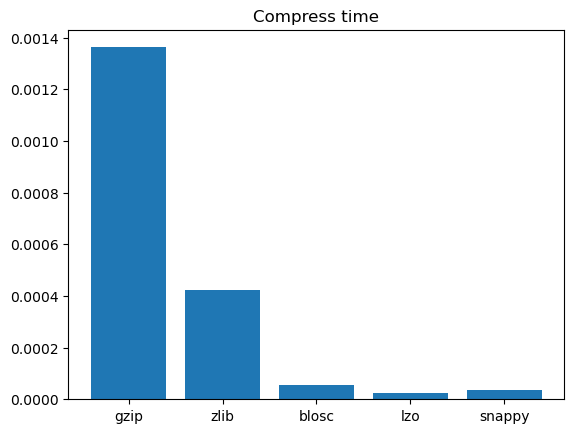

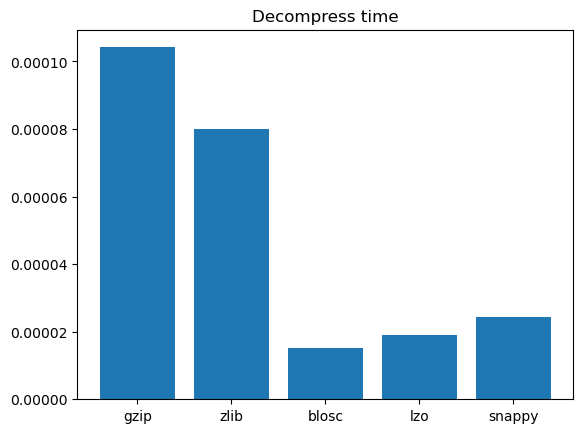

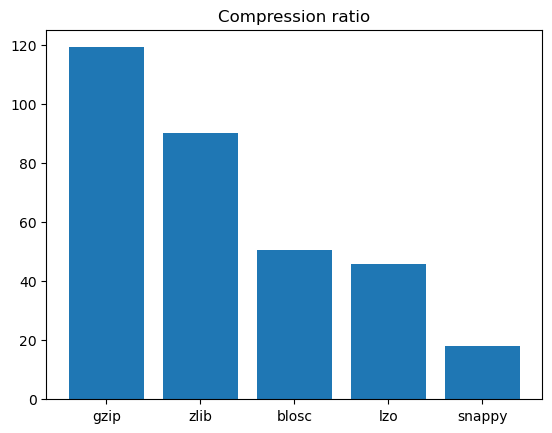

In [4]:
algs = {
    'gzip': (gzip.compress, gzip.decompress),
    'zlib': (zlib.compress, zlib.decompress),
    'blosc': (partial(blosc.compress, typesize=x.itemsize), blosc.decompress),
    'lzo': (lzo.compress, lzo.decompress),
    'snappy': (snappy.compress, snappy.decompress),
}
result = OrderedDict()
for name, (c, d) in algs.items():
    result[name] = evaluate(c, d, x)

plt.title('Compress time')
plt.bar(result.keys(), list(map(lambda v: v['compress_time'], result.values())))

plt.figure()
plt.title('Decompress time')
plt.bar(result.keys(), list(map(lambda v: v['decompress_time'], result.values())))

plt.figure()
plt.title('Compression ratio')
plt.bar(result.keys(), list(map(lambda v: v['ratio'], result.values())))